In [ ]:
import os
import numpy as np
from PIL import Image
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from sklearn.metrics import classification_report
from sklearn.utils import shuffle

In [3]:
# Get the current working directory
current_directory = os.getcwd()
current_directory

'c:\\Users\\X571\\Downloads\\DeepLearning24_25'

In [4]:
class MacenkoNormalization:
    def __init__(self):
        pass

    def __call__(self, image ):
      """
      Implements the staining normalization method from
        Macenko M. et al. "A method for normalizing histology slides for
        quantitative analysis". ISBI 2009
      :param im:
      :param alpha:
      :param beta:
      :return:

      References:
      [1] Macenko M. et al. "A method for normalizing histology slides for quantitative analysis". ISBI 2009
      [2]

      """

      img = np.array(image)



      Io = 240 # Transmitted light intensity, Normalizing factor for image intensities
      alpha = 1  #As recommend in the paper. tolerance for the pseudo-min and pseudo-max (default: 1)
      beta = 0.15 #As recommended in the paper. OD threshold for transparent pixels (default: 0.15)


      ######## Step 1: Convert RGB to OD ###################
      ## reference H&E OD matrix.
      #Can be updated if you know the best values for your image.
      #Otherwise use the following default values.
      #Read the above referenced papers on this topic.
      HERef = np.array([[0.5626, 0.2159],
                        [0.7201, 0.8012],
                        [0.4062, 0.5581]])


      ### reference maximum stain concentrations for H&E
      maxCRef = np.array([1.9705, 1.0308])


      # extract the height, width and num of channels of image
      h, w, c = img.shape


      # reshape image to multiple rows and 3 columns.
      #Num of rows depends on the image size (wxh)
      img = img.reshape((-1,3))

      # calculate optical density
      # OD = −log10(I)
      #OD = -np.log10(img+0.004)  #Use this when reading images with skimage
      #Adding 0.004 just to avoid log of zero.

      OD = -np.log10((img+1.0)/Io) #Use this for opencv imread
      #Add 1 in case any pixels in the image have a value of 0 (log 0 is indeterminate)


      '''
      from mpl_toolkits.mplot3d import Axes3D

      fig = plt.figure(figsize=(16, 8))
      ax1 = fig.add_subplot(121, projection='3d')
      ax1.scatter(img[:,0],img[:,1],img[:,2])
      ax2 = fig.add_subplot(122, projection='3d')
      ax2.scatter(OD[:,0],OD[:,1],OD[:,2])

      plt.show()
      '''


      ############ Step 2: Remove data with OD intensity less than β ############
      # remove transparent pixels (clear region with no tissue)
      ODhat = OD[~np.any(OD < beta, axis=1)] #Returns an array where OD values are above beta
      #Check by printing ODhat.min()


      ############# Step 3: Calculate SVD on the OD tuples ######################
      #Estimate covariance matrix of ODhat (transposed)
      # and then compute eigen values & eigenvectors.
      eigvals, eigvecs = np.linalg.eigh(np.cov(ODhat.T))


      ######## Step 4: Create plane from the SVD directions with two largest values ######
      #project on the plane spanned by the eigenvectors corresponding to the two
      # largest eigenvalues
      That = ODhat.dot(eigvecs[:,1:3]) #Dot product

      ############### Step 5: Project data onto the plane, and normalize to unit length ###########
      ############## Step 6: Calculate angle of each point wrt the first SVD direction ########
      #find the min and max vectors and project back to OD space
      phi = np.arctan2(That[:,1],That[:,0])

      minPhi = np.percentile(phi, alpha)
      maxPhi = np.percentile(phi, 100-alpha)

      vMin = eigvecs[:,1:3].dot(np.array([(np.cos(minPhi), np.sin(minPhi))]).T)
      vMax = eigvecs[:,1:3].dot(np.array([(np.cos(maxPhi), np.sin(maxPhi))]).T)



      # a heuristic to make the vector corresponding to hematoxylin first and the
      # one corresponding to eosin second
      if vMin[0] > vMax[0]:
          HE = np.array((vMin[:,0], vMax[:,0])).T

      else:
          HE = np.array((vMax[:,0], vMin[:,0])).T


      # rows correspond to channels (RGB), columns to OD values
      Y = np.reshape(OD, (-1, 3)).T

      # determine concentrations of the individual stains
      C = np.linalg.lstsq(HE,Y, rcond=None)[0]

      # normalize stain concentrations
      maxC = np.array([np.percentile(C[0,:], 99), np.percentile(C[1,:],99)])
      tmp = np.divide(maxC,maxCRef)
      C2 = np.divide(C,tmp[:, np.newaxis])

      ###### Step 8: Convert extreme values back to OD space
      # recreate the normalized image using reference mixing matrix
      clipped_values = np.clip(-HERef.dot(C2), a_min=-50, a_max=50)  # Evita overflow
      Inorm = np.multiply(Io, np.exp(clipped_values))
      Inorm[Inorm>255] = 254
      Inorm = np.reshape(Inorm.T, (h, w, 3)).astype(np.uint8)

      # Separating H and E components
      '''
      H = np.multiply(Io, np.exp(np.expand_dims(-HERef[:,0], axis=1).dot(np.expand_dims(C2[0,:], axis=0))))
      H[H>255] = 254
      H = np.reshape(H.T, (h, w, 3)).astype(np.uint8)

      E = np.multiply(Io, np.exp(np.expand_dims(-HERef[:,1], axis=1).dot(np.expand_dims(C2[1,:], axis=0))))
      E[E>255] = 254
      E = np.reshape(E.T, (h, w, 3)).astype(np.uint8)

        C = ((C - C.min()) / (C.max() - C.min()) * 255).astype(np.uint8)
      '''
      return Image.fromarray(Inorm)

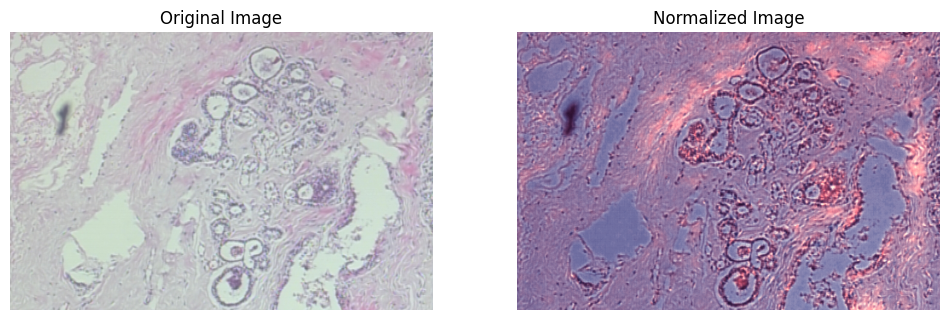

In [5]:
import matplotlib.pyplot as plt
from PIL import Image

# Create an instance of the MacenkoNormalization class
macenko_normalizer = MacenkoNormalization()

# Load the original image
image_path = current_directory + '/data_p1/benign/SOB_B_A-14-22549AB-40-001.png'
image = Image.open(image_path)

# Apply normalization
normalized_image = macenko_normalizer(image)

# Plot the original and normalized images side by side
plt.figure(figsize=(12, 6))

# Original image
plt.subplot(1, 2, 1)
plt.imshow(image)
plt.title("Original Image")
plt.axis("off")

# Normalized image
plt.subplot(1, 2, 2)
plt.imshow(normalized_image)
plt.title("Normalized Image")
plt.axis("off")

plt.show()


In [6]:
# Define the paths to train, validation, and test directories
train_directory = current_directory + '/data_p1/train'
val_directory = current_directory + '/data_p1/val'
test_directory = current_directory + '/data_p1/test'

# Function to count the number of images in a directory
def count_images(directory):
    class_counts = {}
    for folder in os.listdir(directory):
        folder_path = os.path.join(directory, folder)
        if os.path.isdir(folder_path):
            class_counts[folder] = len([
                file for file in os.listdir(folder_path) 
                if file.lower().endswith(('.png', '.jpg', '.jpeg', '.tif', '.bmp'))
            ])
    return class_counts

# Count images in train, validation, and test directories for each class
train_class_counts = count_images(train_directory)
val_class_counts = count_images(val_directory)
test_class_counts = count_images(test_directory)

# Display the counts
print("Number of images in each class in the train directory:")
print(train_class_counts)

print("\nNumber of images in each class in the validation directory:")
print(val_class_counts)

print("\nNumber of images in each class in the test directory:")
print(test_class_counts)


Number of images in each class in the train directory:
{'benign': 1488, 'malignant': 3257}

Number of images in each class in the validation directory:
{'benign': 495, 'malignant': 1087}

Number of images in each class in the test directory:
{'benign': 497, 'malignant': 1085}


Checking the shapes of the images

In [7]:
# Define the paths to train, validation, and test directories
train_directory = current_directory + '/data_p1_normalized/train'
val_directory = current_directory + '/data_p1_normalized/val'
test_directory = current_directory + '/data_p1_normalized/test'

# Function to find the largest and smallest images in a directory
def find_extreme_images(directory):
    # Define the variables for the smallest and largest images
    largest_image = None
    smallest_image = None
    largest_size = 0
    smallest_size = float('inf')  # Infinite number to initialize

    # Loop through all subfolders in the directory
    for folder in os.listdir(directory):
        folder_path = os.path.join(directory, folder)
        if os.path.isdir(folder_path):  # Ensure it's a directory
            for file in os.listdir(folder_path):
                file_path = os.path.join(folder_path, file)
                if file.lower().endswith(('.png', '.jpg', '.jpeg', '.tif', '.bmp')):
                    # Open the image
                    with Image.open(file_path) as img:
                        img_size = img.size[0] * img.size[1]  # Width * Height to get the size
                        # Update the largest and smallest images if necessary
                        if img_size > largest_size:
                            largest_size = img_size
                            largest_image = file_path, img.size
                        if img_size < smallest_size:
                            smallest_size = img_size
                            smallest_image = file_path, img.size

    return largest_image, smallest_image

# Find the largest and smallest images in train, validation, and test directories
largest_train_image, smallest_train_image = find_extreme_images(train_directory)
largest_val_image, smallest_val_image = find_extreme_images(val_directory)
largest_test_image, smallest_test_image = find_extreme_images(test_directory)

# Print results
print("Largest image in the train directory:")
print("File Path:", largest_train_image[0])
print("Size (Width x Height):", largest_train_image[1])
print("\nSmallest image in the train directory:")
print("File Path:", smallest_train_image[0])
print("Size (Width x Height):", smallest_train_image[1])

print("\nLargest image in the validation directory:")
print("File Path:", largest_val_image[0])
print("Size (Width x Height):", largest_val_image[1])
print("\nSmallest image in the validation directory:")
print("File Path:", smallest_val_image[0])
print("Size (Width x Height):", smallest_val_image[1])

print("\nLargest image in the test directory:")
print("File Path:", largest_test_image[0])
print("Size (Width x Height):", largest_test_image[1])
print("\nSmallest image in the test directory:")
print("File Path:", smallest_test_image[0])
print("Size (Width x Height):", smallest_test_image[1])


Largest image in the train directory:
File Path: c:\Users\X571\Downloads\DeepLearning24_25/data_p1_normalized/train\benign\SOB_B_A-14-22549AB-100-001.png
Size (Width x Height): (700, 460)

Smallest image in the train directory:
File Path: c:\Users\X571\Downloads\DeepLearning24_25/data_p1_normalized/train\malignant\SOB_M_PC-14-12465-100-001.png
Size (Width x Height): (700, 456)

Largest image in the validation directory:
File Path: c:\Users\X571\Downloads\DeepLearning24_25/data_p1_normalized/val\benign\SOB_B_A-14-22549AB-100-003.png
Size (Width x Height): (700, 460)

Smallest image in the validation directory:
File Path: c:\Users\X571\Downloads\DeepLearning24_25/data_p1_normalized/val\malignant\SOB_M_PC-14-12465-100-004.png
Size (Width x Height): (700, 456)

Largest image in the test directory:
File Path: c:\Users\X571\Downloads\DeepLearning24_25/data_p1_normalized/test\benign\SOB_B_A-14-22549AB-100-002.png
Size (Width x Height): (700, 460)

Smallest image in the test directory:
File Pa

Resizing

In [8]:
source_folders = ['benign', 'malignant']

# Initialize empty lists for train and test data
X_train = []
y_train = []
X_val = []
y_val = []
X_test = []
y_test = []

# Function to resize images and create numpy arrays
def resize_and_create_arrays(directory, X, y, target_size=(128, 128)):
    for folder in os.listdir(directory):
        folder_path = os.path.join(directory, folder)
        if os.path.isdir(folder_path) and folder in source_folders:
            label = source_folders.index(folder)  # 0 for benign, 1 for malignant
            for file in os.listdir(folder_path):
                file_path = os.path.join(folder_path, file)
                try:
                    with Image.open(file_path) as img:
                        # Resize image to target size
                        img_resized = img.resize(target_size)
                        # Convert image to numpy array
                        img_array = np.array(img_resized)
                        # Append image array to X and label to y
                        X.append(img_array)
                        y.append(label)
                except Exception as e:
                    print(f"Error processing {file_path}: {e}")

# Resize images and create arrays for the train directory
resize_and_create_arrays(train_directory, X_train, y_train)

# Resize images andcreate arrays for the val directory
resize_and_create_arrays(val_directory, X_val, y_val)

# Resize images andcreate arrays for the test directory
resize_and_create_arrays(test_directory, X_test, y_test)

# Convert lists to numpy arrays
X_train = np.array(X_train)
y_train = np.array(y_train)
X_val = np.array(X_val)
y_val = np.array(y_val)
X_test = np.array(X_test)
y_test = np.array(y_test)

# Print dataset information
print("Resized images and created X and y arrays.")
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_val shape:", X_val.shape)
print("y_val shape:", y_val.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

Resized images and created X and y arrays.
X_train shape: (4745, 128, 128, 3)
y_train shape: (4745,)
X_val shape: (1582, 128, 128, 3)
y_val shape: (1582,)
X_test shape: (1582, 128, 128, 3)
y_test shape: (1582,)


Rescalling

In [9]:
X_train = X_train.astype('float32') / 255
X_val = X_val.astype('float32') / 255
X_test = X_test.astype('float32') / 255

In [10]:
X_train, y_train = shuffle(X_train, y_train, random_state=42)


In [11]:
X_train = tf.constant(X_train, dtype='float32')
X_test = tf.constant(X_test, dtype='float32')
X_val = tf.constant(X_val, dtype='float32')
y_val = tf.constant(y_val, dtype='float32')
y_train = tf.constant(y_train, dtype='float32')
y_test = tf.constant(y_test, dtype='float32')

CNN

In [12]:
model = Sequential()
model.add(Conv2D(filters=40, activation='relu',kernel_size=3, padding='same')) 
model.add(Conv2D(filters=40, activation='relu',kernel_size=3, padding='same')) 

model.add(Flatten())

model.add(Dense(100, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

# compile model
model.compile(optimizer="adam", loss='binary_crossentropy', metrics=['accuracy'])

In [13]:
# Train the model
history = model.fit(
   X_train, y_train, batch_size=32,
    epochs=20,
    validation_data=(X_val, y_val),
     verbose=1
)

Epoch 1/20
149/149 [==============================] - 332s 2s/step - loss: 1.9037 - accuracy: 0.6856 - val_loss: 0.5566 - val_accuracy: 0.6991
Epoch 2/20
149/149 [==============================] - 280s 2s/step - loss: 0.5458 - accuracy: 0.7364 - val_loss: 0.5182 - val_accuracy: 0.7440
Epoch 3/20
149/149 [==============================] - 268s 2s/step - loss: 0.5026 - accuracy: 0.7640 - val_loss: 0.5612 - val_accuracy: 0.7453
Epoch 4/20
149/149 [==============================] - 266s 2s/step - loss: 0.4231 - accuracy: 0.8082 - val_loss: 0.5330 - val_accuracy: 0.7560
Epoch 5/20
149/149 [==============================] - 271s 2s/step - loss: 0.2642 - accuracy: 0.8934 - val_loss: 0.6125 - val_accuracy: 0.7623
Epoch 6/20
149/149 [==============================] - 271s 2s/step - loss: 0.0896 - accuracy: 0.9734 - val_loss: 0.8279 - val_accuracy: 0.6568
Epoch 7/20
149/149 [==============================] - 307s 2s/step - loss: 0.0274 - accuracy: 0.9952 - val_loss: 0.9473 - val_accuracy: 0.7238

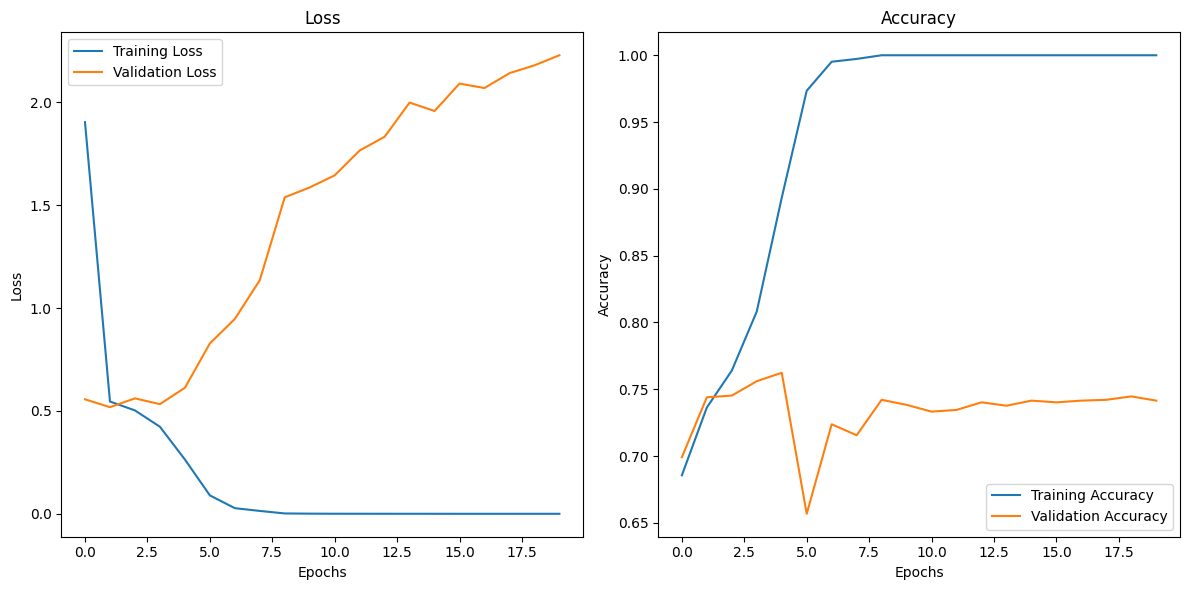

In [14]:
# Plotting training and validation loss and accuracy
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [15]:
y_test_predicted = model.predict(X_test)
y_test_predicted = [float(el.argmax()) for el in y_test_predicted]

test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_accuracy}\n\n')

print(classification_report(y_test, y_test_predicted))

50/50 [==============================] - 8s 168ms/step - loss: 2.0528 - accuracy: 0.7472
Test Loss: 2.0527632236480713
Test Accuracy: 0.747155487537384




NameError: name 'classification_report' is not defined